# ViT

## Import packages

In [ ]:
!pip install torchinfo

from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchinfo import summary

import os
import time
from tqdm.notebook import tqdm

## Set device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda", "Failed to allocate the GPU"
print(device)

cuda


## Set parameters

In [ ]:
input_channel = 3
image_size = 32
n_class = 10
batch_size = 512

input_size = (batch_size, input_channel, image_size, image_size)

## Prepare dataset

In [ ]:
data_path = "content/data"

to_tensor = transforms.ToTensor()

train_dataset = datasets.CIFAR10(data_path, train=True, transform=to_tensor, download=True)
valid_dataset = datasets.CIFAR10(data_path, train=False, transform=to_tensor, download=True)
print(len(train_dataset))
print(len(valid_dataset))

100%|██████████| 170498071/170498071 [00:01<00:00, 104449138.60it/s]


Extracting content/data/cifar-10-python.tar.gz to content/data
Files already downloaded and verified
50000
10000


### Checking images

(3, 36, 138)
(36, 138, 3)


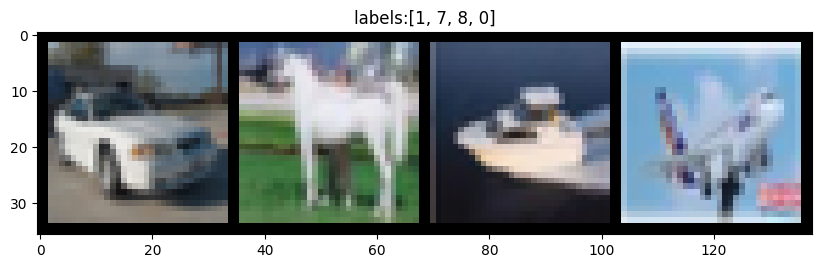

In [ ]:
def show(img, y=None):
    img = img.numpy()
    print(np.shape(img))
    img = np.transpose(img, (1, 2, 0))
    print(np.shape(img))
    plt.imshow(img)

    if y is not None:
        plt.title('labels:' + str(y))


np.random.seed(10)
torch.manual_seed(0)

grid_size = 4
rnd_ind = np.random.randint(0, len(train_dataset), grid_size)

x_grid = [train_dataset[i][0] for i in rnd_ind]
y_grid = [train_dataset[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10, 10))
show(x_grid, y_grid)

### Applying data augmentation

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomCrop(image_size, padding=4),
    transforms.RandomHorizontalFlip()
])
valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset.transform = train_transform
valid_dataset.transform = valid_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_feature, train_label = next(iter(train_loader))
print(f"Feature batch shape: {train_feature.size()}")
print(f"Label batch shape: {train_label.size()}")

Feature batch shape: torch.Size([512, 3, 32, 32])
Label batch shape: torch.Size([512])


### Checking augmented images

(3, 36, 138)
(36, 138, 3)


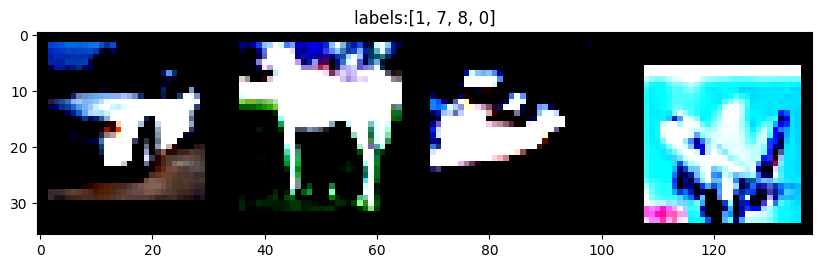

In [ ]:
np.random.seed(10)
torch.manual_seed(0)

grid_size = 4
rnd_ind = np.random.randint(0, len(train_dataset), grid_size)

x_grid = [train_dataset[i][0] for i in rnd_ind]
y_grid = [train_dataset[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10, 10))
show(x_grid, y_grid)

## Model construct

### Set parameters for model

In [ ]:
patch_size = 4
proj_dim = 768
mlp_hidden_dim = 512
transformer_layers = 6
num_heads = 8
num_patches = int((image_size * image_size) / (patch_size * patch_size)) + 1

### Set parameters for training

In [ ]:
dropout_rate = 0.1
lr = 1e-4
num_epoch = 200
early_stopping_patience = 10

### Patch embedding

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 patch_size=patch_size,
                 input_channel=input_channel,
                 proj_dim=proj_dim):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, proj_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, images):
        x = self.proj(images)
        x = x.flatten(2)
        x = x.transpose(1, 2)

        return x

In [ ]:
patch_embedding = PatchEmbedding(patch_size=patch_size, input_channel=input_channel, proj_dim=proj_dim).to(device)
dummy_input = torch.randn(batch_size, input_channel, image_size, image_size).to(device)
output_patch_embedding = patch_embedding(dummy_input)
print(output_patch_embedding.size())

torch.Size([512, 64, 768])


### Class tokenization

In [ ]:
class ClsToken(nn.Module):
    def __init__(self, proj_dim=proj_dim):
        super().__init__()
        self.cls_token = nn.Parameter(torch.zeros(1, 1, proj_dim))

    def forward(self, x):
        n_samples = x.shape[0]
        cls_token = self.cls_token.expand(n_samples, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        return x

In [ ]:
cls_token = ClsToken(proj_dim=proj_dim).to(device)
output_cls_token = cls_token(output_patch_embedding)
print(output_cls_token.size())

torch.Size([512, 65, 768])


### Position embedding

In [ ]:
class PositionEmbedding(nn.Module):
    def __init__(self, device, dropout_rate=0.0):
        super().__init__()
        self.device = device

        self.p_drop = nn.Dropout(dropout_rate)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, proj_dim)).to(self.device)

    def forward(self, patch):
        encoded = patch + self.pos_embed
        encoded = self.p_drop(encoded)

        return encoded

In [ ]:
position_embedding = PositionEmbedding(device=device, dropout_rate=dropout_rate).to(device)
output_position_embedding = position_embedding(output_cls_token)
print(output_position_embedding.size())

torch.Size([512, 65, 768])


### Multi Head Attention

In [ ]:
class MHA(nn.Module):
    def __init__(self, dim, heads=8, qkv_bias=False, qk_scale=None, dropout_rate=0.0):
        super().__init__()
        self.num_heads = heads
        head_dim = dim // heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(dropout_rate)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout_rate)

    def forward(self, x):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

### MLP block

In [ ]:
class MlpBlock(nn.Module):
    def __init__(self, in_channel, out_channel, dropout_rate=0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_channel, out_channel)
        self.attn = nn.GELU()
        self.fc2 = nn.Linear(out_channel, in_channel)
        self.drop = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.attn(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)

        return x

### MLP head

In [ ]:
class MlpHead(nn.Module):
    def __init__(self, projection_dim, n_class):
        super().__init__()
        self.norm = nn.LayerNorm(projection_dim, eps=1e-6)
        self.head = nn.Linear(projection_dim, n_class)

    def forward(self, x):
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)

        return x

### Transformer

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, projection_dim, num_heads, mlp_hidden_dim, qkv_bias=False, dropout_rate=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(projection_dim, eps=1e-6)
        self.attn = MHA(
            projection_dim,
            heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate
        )

        self.norm2 = nn.LayerNorm(projection_dim, eps=1e-6)

        self.mlp = MlpBlock(
            in_channel=projection_dim,
            out_channel=mlp_hidden_dim,
            dropout_rate=dropout_rate
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x

### Vision Transformer

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
            self,
            device,
            patch_size,
            n_class,
            projection_dim,
            depth,
            num_heads,
            qkv_bias=True,
            dropout_rate=0.0
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_size)
        self.position_embed = PositionEmbedding(dropout_rate=dropout_rate, device=device)
        self.cls_token = ClsToken(projection_dim)
        self.blocks = nn.ModuleList(
            [
                TransformerBlock(
                    projection_dim,
                    num_heads,
                    mlp_hidden_dim,
                    qkv_bias=qkv_bias,
                    dropout_rate=dropout_rate
                )
                for _ in range(depth)
            ]
        )

        self.mlp_head = MlpHead(projection_dim, n_class)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.cls_token(x)
        x = self.position_embed(x)

        for i, block in enumerate(self.blocks):
            x = block(x)

        output = self.mlp_head(x)

        return output

### Get model

In [ ]:
def export_model(
        model,
        export_name="model.pt",
        save_as_checkpoint=False, model_state_dict=None, optimizer_state_dict=None, loss=None, epoch=None):
    if save_as_checkpoint:
        if None in (model_state_dict, optimizer_state_dict, loss):
            raise Exception("Something is None")

        torch.save({
            "epoch": epoch,
            "model_state_dict": model_state_dict,
            "optimizer_state_dict": optimizer_state_dict,
            "loss": loss}, f=export_name)
    else:
        torch.save(model.state_dict(), f=export_name)

In [ ]:
vit_model = VisionTransformer(
    device=device,
    patch_size=patch_size,
    n_class=n_class,
    projection_dim=proj_dim,
    depth=transformer_layers,
    num_heads=num_heads,
    dropout_rate=dropout_rate
)
summary(model=vit_model, input_size=(batch_size, 3, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [512, 10]                 --
├─PatchEmbedding: 1-1                    [512, 64, 768]            --
│    └─Conv2d: 2-1                       [512, 768, 8, 8]          37,632
├─ClsToken: 1-2                          [512, 65, 768]            768
├─PositionEmbedding: 1-3                 [512, 65, 768]            --
│    └─Dropout: 2-2                      [512, 65, 768]            --
├─ModuleList: 1-4                        --                        --
│    └─TransformerBlock: 2-3             [512, 65, 768]            --
│    │    └─LayerNorm: 3-1               [512, 65, 768]            1,536
│    │    └─MHA: 3-2                     [512, 65, 768]            2,362,368
│    │    └─LayerNorm: 3-3               [512, 65, 768]            1,536
│    │    └─MlpBlock: 3-4                [512, 65, 768]            787,712
│    └─TransformerBlock: 2-4             [512, 65, 768]       

In [ ]:
os.makedirs("model/", exist_ok=True)
export_model(
    model=vit_model,
    export_name="model/dummy_model.pt"
)

## Define loss & optimizer

In [ ]:
ce = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(
    params=vit_model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    num_epoch,
    verbose=True
)

Adjusting learning rate of group 0 to 1.0000e-04.


## Define train & evaluate

### Train

In [ ]:
def train(model, train_loader, optimizer, epoch_cnt):
    model.train()
    train_class_loss = 0
    train_class_correct = 0

    train_tqdm = tqdm(
        iterable=enumerate(train_loader),
        desc=f"Epoch {epoch_cnt}: class_loss: _",
        total=int(len(train_loader.dataset) / batch_size),
        leave=False
    )
    for batch_idx, (x, y_label) in train_tqdm:
        x = x.to(device)
        y_label = y_label.to(device).long()
        y_label = y_label.squeeze(dim=-1)

        optimizer.zero_grad()

        class_out = model(x)

        class_loss_out = ce(class_out, y_label)
        class_loss_out.backward()

        optimizer.step()

        train_class_loss += class_loss_out.item()
        prediction = class_out.max(1, keepdim=True)[1]
        train_class_correct += prediction.eq(y_label.view_as(prediction)).sum().item()

        train_tqdm.set_description(
            desc=f"Epoch {epoch_cnt}: class_loss: {class_loss_out.item():.4f};"
        )

    train_class_loss /= (len(train_loader.dataset) / batch_size)
    train_class_acc = 100. * train_class_correct / len(train_loader.dataset)

    return model, train_class_loss, train_class_acc

### Evaluate

In [ ]:
def evaluate(model, test_loader, return_cls_output=False):
    model.eval()
    test_class_loss = 0
    test_class_correct = 0
    cls_target = np.array([])
    cls_output = np.array([])
    with torch.no_grad():
        test_tqdm = tqdm(
            iterable=enumerate(test_loader),
            desc="Evaluate batch_idx _: class_loss: _;",
            total=int(len(test_loader.dataset) / batch_size),
            leave=False
        )
        for batch_idx, (x, y_label) in test_tqdm:
            x = x.to(device)
            y_label = y_label.to(device).long()
            y_label = y_label.squeeze(dim=-1)

            class_out = model(x)

            if return_cls_output:
                cls_target = np.append(cls_target, y_label.cpu().detach().numpy())
                cls_output = np.append(cls_output, np.argmax(class_out.cpu().detach().numpy(), axis=1))

            class_loss_out = ce(class_out, y_label)

            test_class_loss += class_loss_out.item()
            prediction = class_out.max(1, keepdim=True)[1]
            test_class_correct += prediction.eq(y_label.view_as(prediction)).sum().item()

            test_tqdm.set_description(
                f"Evaluate batch_idx {batch_idx}: class_loss: {class_loss_out.item():.4f};"
            )

    test_class_loss /= (len(test_loader.dataset) / batch_size)
    test_class_acc = 100. * test_class_correct / len(test_loader.dataset)

    if return_cls_output is False:
        return model, test_class_loss, test_class_acc
    else:
        return model, test_class_loss, test_class_acc, (cls_target, cls_output)

## Training

### Define logger

In [ ]:
from torch.utils.tensorboard import SummaryWriter


def get_time():
    local_time = time.localtime()

    output = ""
    for i, _time in enumerate(local_time):
        output += f"{_time}"
        if i == 5:
            break
        output += "_"

    return output


writer = SummaryWriter(log_dir=os.path.join("log", get_time()))

### Set parameters

In [ ]:
import sys

best_valid_loss = sys.float_info.max
early_stopping_cnt = 0

### Training

In [ ]:
start_time = time.time()
os.makedirs("ckpt/", exist_ok=True)

for epoch in range(1, num_epoch):
    vit_model, train_loss, train_acc = train(
        model=vit_model,
        train_loader=train_loader,
        optimizer=scheduler.optimizer,
        epoch_cnt=epoch
    )
    print(f"\n[EPOCH: {epoch}] - Train Loss: {train_loss:.4f}; Train Accuracy: {train_acc:.2f}%")

    vit_model, valid_loss, valid_acc = evaluate(model=vit_model, test_loader=valid_loader)
    print(f"\n[EPOCH: {epoch}] - Valid Loss: {valid_loss:.4f}; Valid Accuracy: {valid_acc:.2f}%")

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/valid", valid_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/valid", valid_acc, epoch)
    writer.add_scalar("Learning Rate", float(optimizer.param_groups[0]["lr"]), epoch)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stopping_cnt = 0

        export_model(
            model=vit_model,
            export_name=f"ckpt/ckpt_{valid_loss:.4f}.pt",
            save_as_checkpoint=True,
            model_state_dict=vit_model.state_dict(),
            optimizer_state_dict=scheduler.optimizer.state_dict(),
            loss=ce,
            epoch=epoch
        )
    else:
        early_stopping_cnt += 1
        print(f"Valid loss didn't improved from {best_valid_loss:.4f}; current: {valid_loss:.4f}")
        print(f"Early stopping - {early_stopping_cnt} / {early_stopping_patience}")
        if early_stopping_cnt >= early_stopping_patience:
            print("Early stopping triggered")
            break

    scheduler.step(valid_loss)

print(f"Training time: {time.time() - start_time}s")

Epoch 1: class_loss: _:   0%|          | 0/97 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Testing

In [ ]:
vit_model = VisionTransformer(
    device=device,
    patch_size=patch_size,
    n_class=n_class,
    projection_dim=proj_dim,
    depth=transformer_layers,
    num_heads=num_heads,
    dropout_rate=dropout_rate
)
ckpt = torch.load("/ckpt/ckpt_0.8651.pt")
vit_model.load_state_dict(ckpt["model_state_dict"])
summary(vit_model, input_size=(batch_size, 3, image_size, image_size))

RuntimeError: ignored

In [ ]:
valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
valid_dataset = datasets.CIFAR10(root="content/data", train=False, transform=valid_transform)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
vit_model, valid_loss, valid_acc, outputs = evaluate(
    model=vit_model,
    test_loader=valid_loader,
    return_cls_output=True
)
print(valid_loss)
print(valid_acc)